## Demonstration of dl_kcat
#### Author: E Karvelis
#### Date: 10/27/2023
#### Purpose:
The dl_kcat repository maintains scripts for training and evaluating deep learning models on the Tidor lab's dataset of simulated reaction attempts across 56 different KARI enzyme variants. These scripts train LSTM-based and transformer-based models to map from sets of simulations (from a given variant) to overall specific activity. In an alternative learning task, these models can instead be trained to differentiate between dynamic simulations that eventually succeed in reacting vs. those that fail. 

##### Setting up the Python environment
If you wish to run this notebook yourself, be sure to first check the dependences inside `../../dl_kcat/requirements.txt`,
which can be installed by running ```pip install -r requirements.txt``` inside a
newly created Python virtual environment. See [here](https://docs.python.org/3/library/venv.html)
for more information on virtual environments.

### Set the path to dl_kcat repo

In [3]:
# Enter the path to your local '.../dl_kcat/' repo folder, if needed
loc = '../'

### Import packages

In [4]:
import sys
import time
from IPython.display import Image
sys.path.append(loc+'scripts/')
from prep_data import *
from pred_kcat import *
from transformer_1 import *
from lstm_1 import *
mp.set_start_method('spawn')

### What are the data?

We have collected thousands of simulations of failed and successful reactions for each of 56 unique KARI enzyme variants. In each simulation, there are a few hundred fs describing motion in the reactant well leading up the event of the attempted reaction, which lasts tens of fs. The simulations also include at least 100 fs following the attempt.

The reaction that we are simulating is the methyl transfer shown below:

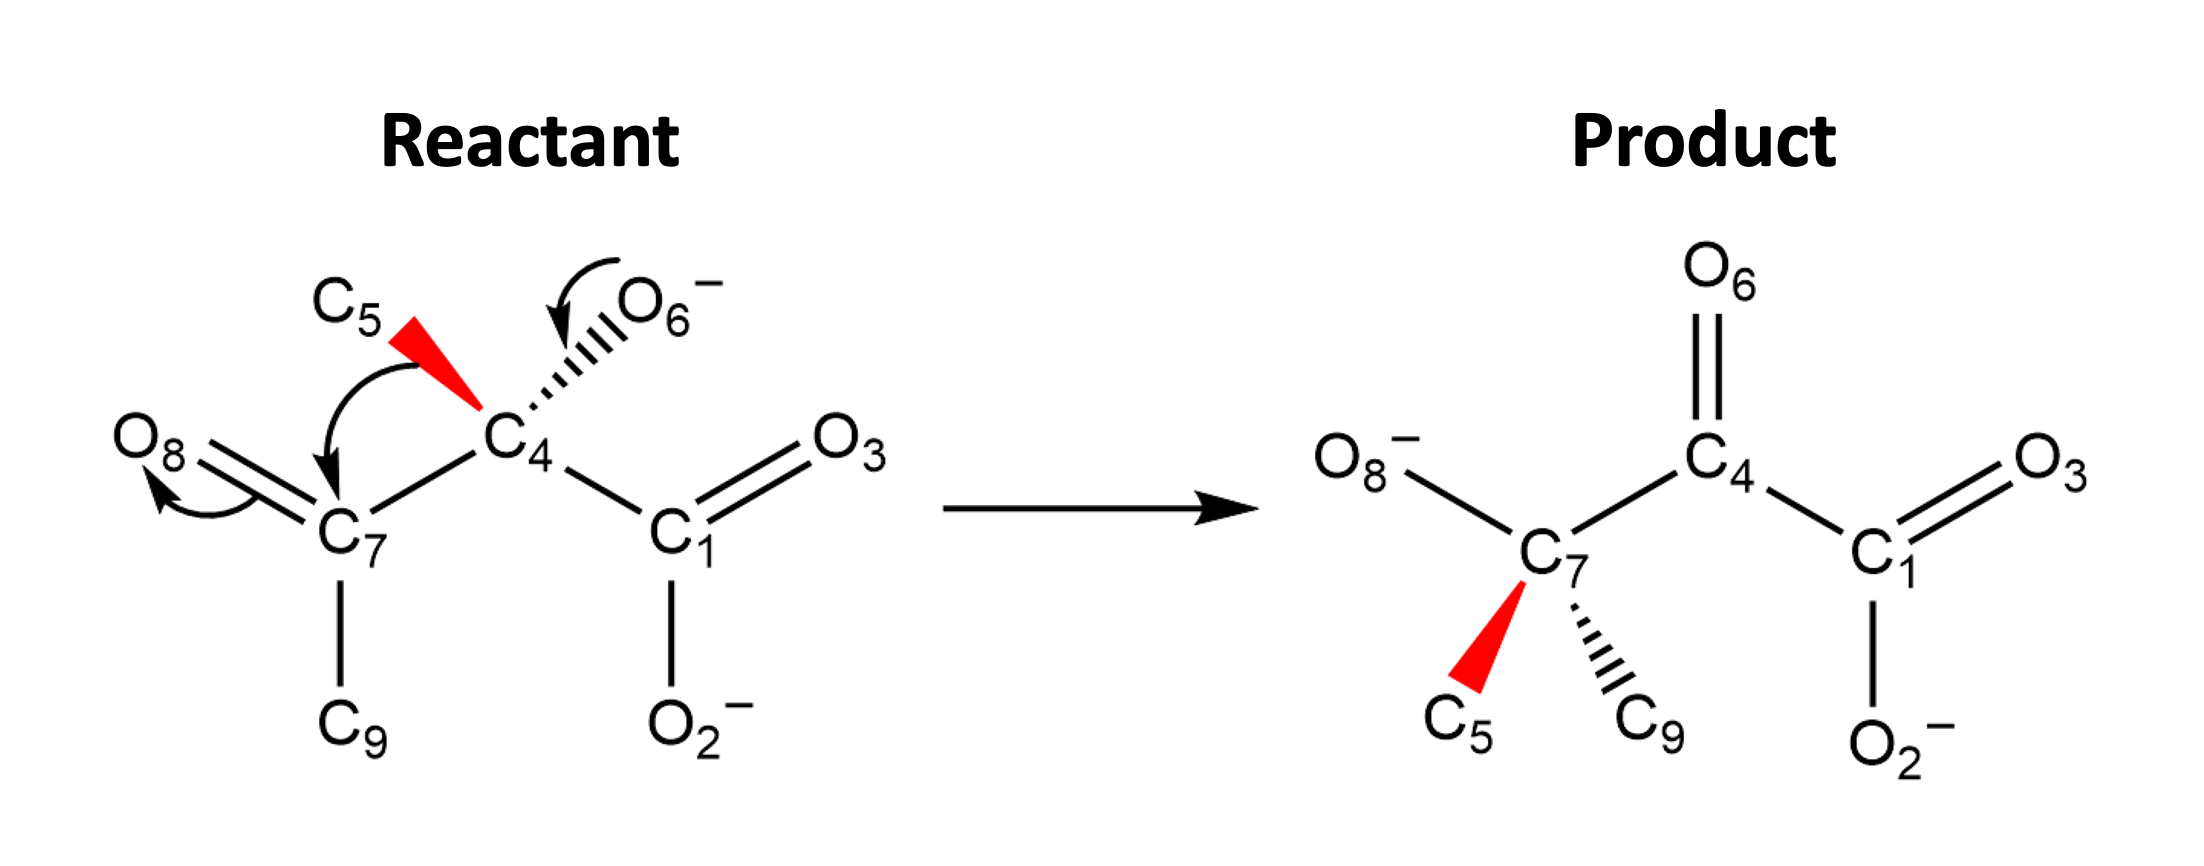

In [3]:
Image(filename='./figs/rxn.png', width=600)

Note that $C_{5}$ is originally bound to $C_{4}$ in the reactant, but it is transfered during the reaction and bound to $C_{7}$ in the product.

We can loosely track reaction progress using an order parameter (not necessarily a valid reaction coordinate), called $\lambda$, which is defined as the length of the breaking bond minus the length of the bond being formed:

$\lambda = d(C_{5}, C_{4}) - d(C_{5}, C_{7})$

where $d$ returns the distance between its two arguments.

In practice, $\lambda$ ranges from about $-1$ in the reactant well to $+1$ in the product well.


Let's look at an example of a successful reaction below, which we sampled using [transition interface sampling (TIS)](https://pubs.aip.org/aip/jcp/article/118/17/7762/185320/A-novel-path-sampling-method-for-the-calculation). You may also view this gif in the README. Substrate is shown in light orange. NADPH is light purple. Mg ions are shown as white spheres with their coordinating waters in stick representation:

In [ ]:
Image(open('./figs/r1-opt.gif', 'rb').read(), width=300)
# CLEAR OUTPUT BEFORE PROCEEDING

Now, let's look at an example of a failed reaction. You may also view this gif in the README. Watch closely how $C_{5}$ makes progress toward the left, but hitches about halfway and ultimately returns to its starting point bound to $C_{4}$:

In [ ]:
Image(open('./figs/nr2-opt.gif', 'rb').read(), width=300)
# CLEAR OUTPUT BEFORE PROCEEDING

#### Before continuing, it's recommended that you clear the above blocks' output

## Loading and handling data
For each enzyme variant, there are thousands of simulations of successful and failed reactions. These were sampled using [TIS](https://pubs.aip.org/aip/jcp/article/118/17/7762/185320/A-novel-path-sampling-method-for-the-calculation). That is, multiple ensembles of simulated reaction attempts were collected for each variant. 

For each simulation in each ensemble, which we call a 'pathway,' 70 geometric features describing the structure of the active site were calculated. These are a mixture of interatomic distances, angles, and dihedrals.

The `.../dl_kcat/scripts/prep_data.py` script handles the compilation of all of these data into a single dataset, which is stored as a memory-mapped numpy array with a corresponding object that contains metadata. This script allows one to specify which pathway ensembles to include for each enzyme variant. Unless you are part of the Tidor lab, you can't run `prep_data.py`, so this step was completed previously inside `.../dl_kcat/demo/prep_data/` to make a ***small dataset for demonstration purposes only***. That is, this dataset only contains 6/56 variants from the full dataset, and only a subset of pathways were randomly sampled for each variant. The dataset files were saved to 

*memory-mapped array:*
``` 
.../dl_kcat/demo/prep_data/data/tptrue_gsfalse_o-0dot4_0dot8_s1_2_3_4_5_r1_2_t-200_100_sub100_numNone.12000-301-70memnpy 
```

*metadata object:*
``` 
.../dl_kcat/demo/prep_data/data/tptrue_gsfalse_o-0dot4_0dot8_s1_2_3_4_5_r1_2_t-200_100_sub100_numNone.12000-301-70metadata 
```

We will work directly with these files as starting points.

In [3]:
# Create a PathDataset object, called data
# The actual data will be in data.data
# The metadata will be in data.meta
data_file = f'{loc}demo/prep_data/data/tptrue_gsfalse_o-0dot4_0dot8_s1_2_3_4_5_r1_2_t-200_100_sub100_numNone.12000-301-70memnpy'
meta_file = f'{loc}demo/prep_data/data/tptrue_gsfalse_o-0dot4_0dot8_s1_2_3_4_5_r1_2_t-200_100_sub100_numNone.12000-301-70metadata'
data = PathDataset(data_file, meta_file)

print (f'Shape of data [pathways, timesteps, features]: {data.data.shape}\n')

# The metadata object in data.meta stores information pertaining to each pathway
# along the first axis of data.data: the variant it comes from, the kcat (activity)
# label for that variant, the order of the pathway (whether it is successfully 
# reactive or failed), as well as information regarding from which ensemble that 
# pathway came (determined by seed and replicate) and where in that ensemble the 
# pathway was sampled (designated by ID). Let's see which attributes have which 
# information:
print ('Metadata object attributes:')
print (data.meta.info())

Shape of data [pathways, timesteps, features]: (12000, 301, 70)

Metadata object attributes:
self.data -- data matrix, X of form [pathways, time points, features]
self.variant -- list of variant identities for each entry along axis 0 of self.data
self.kcat -- list of variant's TIS-based kcat AVG for each entry along axis 0 of self.data
self.kcat_sem -- list of variant's TIS-based kcat SEM for each entry along axis 0 of self.data
self.order -- list of pathway type's order parameter entry along axis 0 of self.data
self.seed -- list of pathway's seed paths along axis 0 of self.data
self.replicate -- list of pathway's replicate number along axis 0 of self.data
self.ids -- list of the pathway's IDs along axis 0 of self.data
self.timesteps -- array of the time steps labels along axis 1 of self.data
self.ft_names -- array of the names of faetures along the last axis of self.data
None


##### Which variants are in our dataset, and what are their $k_{cat}$ values?

In [4]:
variants = np.unique(data.meta.variant)
kcats = [data.meta.kcat[np.where(np.array(data.meta.variant )== v)[0][0]] for v in variants]

print ('Variant           log10(kcat)', 
       '\n-----------------------------')
for i,v in enumerate(variants):
    print (f'{v:20s} {np.log10(kcats[i]):.4f}')

Variant           log10(kcat) 
-----------------------------
Gln140Met-Thr520Asp  -11.7773
Glu492Asn            -18.5436
Leu501His            -12.7496
Met472Lys            -18.9101
Thr520Asp-Leu199Hie  -14.0665
WT                   -16.0214


We have six variants in total: WT, two mutants that are slower than WT (lower $k_{cat}$), and three mutants that are faster than WT.

##### Visualizing reaction progress
Now that the data are loaded, let's visualize the difference in the dynamics of the order parameter, $\lambda$, between successfully reactive ($order = 0.8$) and failed non-reactive paths ($order = -0.4$)

In [22]:
# Let's calculate lambda values at each time point in the first pathway
path = data.data[0]

breaking_bond = path[:,np.where(data.meta.ft_names == 'Dist AC6/C5,AC6/C4')]
making_bond   = path[:,np.where(data.meta.ft_names == 'Dist AC6/C5,AC6/C7')]
lam = breaking_bond - making_bond

print ('Time       Lambda', '\n------------------')
for i,t in enumerate(data.meta.timesteps):
    print (f'{t}       {lam[i][0][0]:.2f}')

Time       Lambda 
------------------
-200       -0.91
-199       -0.91
-198       -0.90
-197       -0.89
-196       -0.89
-195       -0.89
-194       -0.90
-193       -0.90
-192       -0.91
-191       -0.92
-190       -0.94
-189       -0.95
-188       -0.95
-187       -0.96
-186       -0.96
-185       -0.96
-184       -0.96
-183       -0.96
-182       -0.96
-181       -0.96
-180       -0.96
-179       -0.96
-178       -0.97
-177       -0.97
-176       -0.98
-175       -0.98
-174       -0.99
-173       -1.00
-172       -1.01
-171       -1.02
-170       -1.03
-169       -1.05
-168       -1.07
-167       -1.08
-166       -1.10
-165       -1.11
-164       -1.12
-163       -1.13
-162       -1.14
-161       -1.15
-160       -1.15
-159       -1.15
-158       -1.14
-157       -1.13
-156       -1.11
-155       -1.08
-154       -1.05
-153       -1.01
-152       -0.98
-151       -0.94
-150       -0.91
-149       -0.88
-148       -0.85
-147       -0.83
-146       -0.81
-145       -0.80
-144      

Note that lambda begins consistently increasing at t = 0 fs before maximizing around 20 fs. Given its subsequent descent back to lower values, and stabilization near -1, we can see that this was a non-reactive pathway.

Now, let's plot these data for many pathways.

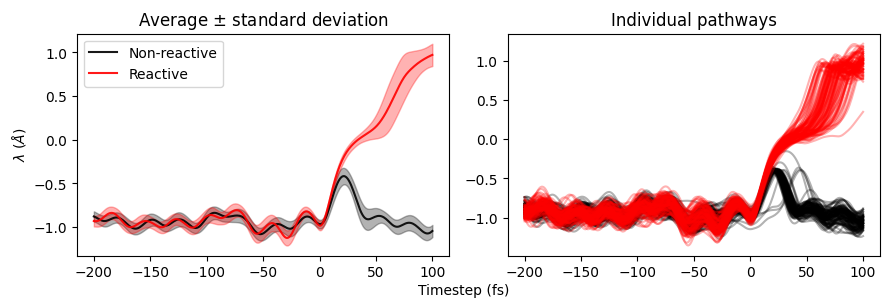

In [11]:
# Use plot_lam (from pred_kcat.py) to plot n = 100 randomly sampled paths
fig = plot_lam(data, n=100)

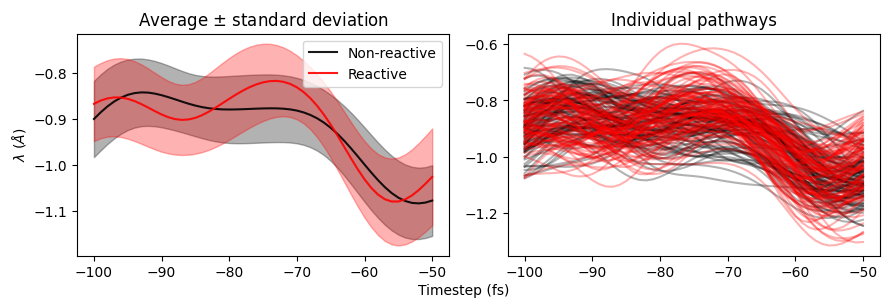

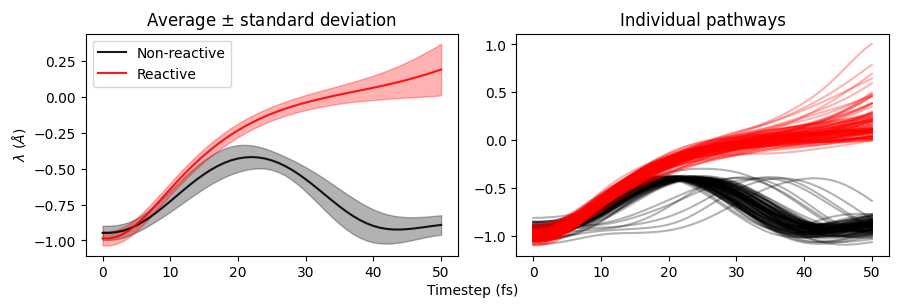

In [50]:
# We can also choose a different time window. E.g.,
time_ranges = [[-100,-50], [0,50]]
for time_range in time_ranges:
    data = PathDataset(data_file, meta_file, time_range=time_range)
    plot_lam(data)

There are obvious differences between non-reactive and reactive pathways at late time points as the reactive paths approach the product well because $\lambda$ was designed to detect whether the substrate was in the reactant or product well.

Interestingly, there are also some (more subtle) differences at early time points before the attempted reaction begins, as indicated by the top plots from -100 to -50 fs. It turns out these differences make it possible to predict whether a given pathway will later succeed, or fail, to react and reach the product well. 

## Training a transformer-based model for non-reactive vs. reactive classification

We will first train a transformer-based model to predict whether a set of pathways are reactive or non-reactive using only their pre-reaction structural dynamics (i.e., using time points before t = 0 fs)

##### Set up 3-fold cross validation

In [7]:
# Define a set of cross validation splits, we will split the training and
# validation sets by the variants. That is, a given variant's pathways will 
# all either be in the training set, or the validation set, but never both
cv_folds = 3
selected_variants = np.unique(data.meta.variant)
cv = KFold(n_splits=cv_folds)
splits = cv.split(selected_variants)

##### Define model and training parameters
The basic setup here is predicting whether a set of 5 pathways (all from the same enzyme variant) is reactive or non-reactive, using only their time series from -160 to -130 fs. 

In [4]:
# For more information on any of these parameters, refer to transformer_1.py

control_model = False
random_seed = 333
path_set_size = 5
batch_size = 16
epochs = 10
output_text = output_text_filename = './transformer_1_output.txt'
stoch_labels = False
features = ['Dist AC6/C5,AC6/C4', 'Dist AC6/C5,AC6/C7', 
            'Dist AC6/C4,AC6/C7', 'Dist AC6/C1,AC6/C4',
            'Ang AC6/C1,AC6/C4,AC6/C7', 'Dihe AC6/C5,AC6/C4,AC6/C7,AC6/C9',
            'Dihe AC6/O6,AC6/C4,AC6/C5,AC6/C5-H','Dihe AC6/O8,AC6/C7,AC6/C5,AC6/C5-H',
            'Dist NDP/H4N2,AC6/C4', 'Dist GLN136/NE2,NDP/O7N', 'Dihe NDP/H1NQ,NDP/C1NQ,NDP/N1N,NDP/C2N', # mode1
            'Ang GLN136/NE2,GLN136/HE22,NDP/O7N',
            'Dist GLU319/OE1,AC6/C5', 'Ang MG6/M17,AC6/O6,MG6/M16']
task = 'NR/R binary classification'
dw_settings = None
parallel_folds = False
mixed_variants = False
regularization = None
time_range = [-160,-130]
warmup_steps = 100

# model parameters
if features[0] == '*':
    input_size =  int(data_file.split('-')[-1].split('memnpy')[0])
else:
    input_size = len(features)
if time_range[0] == '*':
    input_length = int(data_file.split('.')[-1].split('-')[1])
else:
    input_length = int(time_range[1] - time_range[0] + 1)
model_kwargs = {'input_size': input_size,
                'input_length': input_length,
                'd_model': 10,
                'd_input_enc': 10,
                'n_head': 2,
                'd_tran_ffn': 20,
                'dropout_tran_encoder': 0.2,
                'n_tran_layers': 1,
                'd_mlp_head': 10,
                'dropout_mlp_head': 0.2,
                'task': task}

##### Run the cross validation folds
In `lstm_1.py` and `transformer_1.py`, one can specify that the different CV folds are to be trained in parallel. For simplicity, we will here only train them in series, one-at-a-time.

In [9]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('DEVICE: ', device)

for i, (trainset, testset) in enumerate(splits):
    # trainset and testset each hold a list of indexes to split selected_variants
    # into a train and test set of variants, we'll create separate datasets
    # for training and validation comprised, respectively, of only the train 
    # and test variants
    start_time = time.time()
    cv_fold = i+1

    traindata = PathDataset(data_file, meta_file, path_set_size=path_set_size,
                selected_variants=list(selected_variants[trainset]), task=task, 
                features=features, mixed_variants=mixed_variants, time_range=time_range)
    testdata =  PathDataset(data_file, meta_file, path_set_size=path_set_size,
                selected_variants=list(selected_variants[testset]), task=task, 
                features=features, mixed_variants=False, time_range=time_range)
    traindata.make_observations()
    testdata.make_observations()
    
    fold = Fold(cv_fold, traindata, testdata, parallel_folds,
                output_text_filename, model_kwargs, device,
                stoch_labels, dw_settings, control_model, epochs,
                random_seed, batch_size, cv_folds, model_type='transformer encoder',
                train_idxs=None, test_idxs=None, regularization=regularization)
    
    fold.run()

DEVICE:  cuda
Building TransformerModel
Total parameters:     1291
Trainable parameters: 1291


Training variants:
['Leu501His' 'Met472Lys' 'Thr520Asp-Leu199Hie' 'WT'] 


epoch 1 | CV fold 1/3 | 25/100 batches | lr 2.121e-05 | seconds/batch 0.018 | loss 6.923e-01 | sqrt(loss) 8.321e-01 | reg_loss 6.923e-01 | sqrt(reg_loss) 8.321e-01 | acc 0.52750
epoch 1 | CV fold 1/3 | 50/100 batches | lr 4.331e-05 | seconds/batch 0.019 | loss 6.988e-01 | sqrt(loss) 8.360e-01 | reg_loss 6.988e-01 | sqrt(reg_loss) 8.360e-01 | acc 0.50000
epoch 1 | CV fold 1/3 | 75/100 batches | lr 6.541e-05 | seconds/batch 0.019 | loss 6.970e-01 | sqrt(loss) 8.349e-01 | reg_loss 6.970e-01 | sqrt(reg_loss) 8.349e-01 | acc 0.51500
epoch 1 | CV fold 1/3 | 100/100 batches | lr 8.750e-05 | seconds/batch 0.019 | loss 7.065e-01 | sqrt(loss) 8.406e-01 | reg_loss 7.065e-01 | sqrt(reg_loss) 8.406e-01 | acc 0.45750


 --------------------------------------------------------------------------------
End of epoch 1 | CV fold 1/3 |  

In [10]:
# fold.run() saves the weights of several models, we can delete those files
for i in glob('best_model_cvfold*.pt') + glob('model_epoch*_cvfold*.pt'):
    os.remove(i)

# it also wrote transformer_1_output.txt, but this is a copy of the printed output
if os.path.exists('transformer_1_output.txt'):
    os.remove('transformer_1_output.txt')

The data indicate that the model learns general differences between non-reactive and reactive pathways' dynamics, such that the model can distinguish between a new (i.e., unseen by the model) enzyme variant's reactive and non-reactive pathways with (typically) over 90% accuracy.

This means that the characteristics distinguishing reactive from non-reactive pathways generalize across different enzyme variants. 

One might expect there to be a relationship between the balance of reactive vs. non-reactive turnover attemps and overall activity: the more frequently an enzyme variant succeeds in reacting, the higher its measured activity. 

Given that the transformer model could predict whether a forthcoming reaction attempt would be successful, could it also predict whether a variant was significantly more active than the WT enzyme? Let's try this next.

## Training a transformer-based model to predict whether an enzyme mutant will have lower or higher activity than WT, based on its pre-reaction dynamics

We will now train a transformer-based model to predict whether a given enzyme mutant is slower (lower activity) or faster (higher activity) than WT using only pre-reaction structural dynamics (i.e., using time points before t = 0 fs)

##### Set up 3-fold cross validation

In [23]:
# Define a set of cross validation splits, we will split the training and
# validation sets by the variants. That is, a given variant's pathways will 
# all either be in the training set, or the validation set, but never both
cv_folds = 3
selected_variants = np.unique(data.meta.variant)
tmp_kcat = [lookup_kcat(v, data.meta)[0] for v in selected_variants]

cv = StratifiedKFold(n_splits=cv_folds)
y = np.array(np.log10(np.array(tmp_kcat)) > -16.02, dtype=int)
splits = cv.split(selected_variants, y=y)

##### Define model and training parameters
The basic setup here is predicting whether a set of 5 pathways (all from the same enzyme variant) is reactive or non-reactive, using only their time series from -160 to -130 fs.

We'll use all of the same settings from before (for non-reactive vs. reactive pathway prediction), but we do need to update the learning task. We'll also implement an L2 loss and train for fewer epochs.

In [22]:
task = 'S/F binary classification'
model_kwargs['task'] = task
epochs = 5
regularization = {'l2':0.05}

##### Run the cross validation folds
In `lstm_1.py` and `transformer_1.py`, one can specify that the different CV folds are to be trained in parallel. For simplicity, we will here only train them in series, one-at-a-time.

In [8]:
variants = np.unique(data.meta.variant)
kcats = [data.meta.kcat[np.where(np.array(data.meta.variant )== v)[0][0]] for v in variants]

print ('Variant           log10(kcat)', 
       '\n-----------------------------')
for i,v in enumerate(variants):
    print (f'{v:20s} {np.log10(kcats[i]):.4f}')

Variant           log10(kcat) 
-----------------------------
Gln140Met-Thr520Asp  -11.7773
Glu492Asn            -18.5436
Leu501His            -12.7496
Met472Lys            -18.9101
Thr520Asp-Leu199Hie  -14.0665
WT                   -16.0214


In [24]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('DEVICE: ', device)

for i, (trainset, testset) in enumerate(splits):
    # trainset and testset each hold a list of indexes to split selected_variants
    # into a train and test set of variants, we'll create separate datasets
    # for training and validation comprised, respectively, of only the train 
    # and test variants
    start_time = time.time()
    cv_fold = i+1

    traindata = PathDataset(data_file, meta_file, path_set_size=path_set_size,
                selected_variants=list(selected_variants[trainset]), task=task, 
                features=features, mixed_variants=mixed_variants, time_range=time_range)
    testdata =  PathDataset(data_file, meta_file, path_set_size=path_set_size,
                selected_variants=list(selected_variants[testset]), task=task, 
                features=features, mixed_variants=False, time_range=time_range)
    traindata.make_observations()
    testdata.make_observations()
    
    fold = Fold(cv_fold, traindata, testdata, parallel_folds,
                output_text_filename, model_kwargs, device,
                stoch_labels, dw_settings, control_model, epochs,
                random_seed, batch_size, cv_folds, model_type='transformer encoder',
                train_idxs=None, test_idxs=None, regularization=regularization)
    
    fold.run()

DEVICE:  cuda
Building TransformerModel
Total parameters:     1291
Trainable parameters: 1291


Training variants:
['Leu501His' 'Met472Lys' 'Thr520Asp-Leu199Hie' 'WT'] 


epoch 1 | CV fold 1/3 | 25/100 batches | lr 2.121e-05 | seconds/batch 0.017 | loss 7.241e-01 | sqrt(loss) 8.510e-01 | reg_loss 3.632e+00 | sqrt(reg_loss) 1.906e+00 | acc 0.49000
epoch 1 | CV fold 1/3 | 50/100 batches | lr 4.331e-05 | seconds/batch 0.018 | loss 7.136e-01 | sqrt(loss) 8.448e-01 | reg_loss 3.612e+00 | sqrt(reg_loss) 1.901e+00 | acc 0.53000
epoch 1 | CV fold 1/3 | 75/100 batches | lr 6.541e-05 | seconds/batch 0.022 | loss 7.198e-01 | sqrt(loss) 8.484e-01 | reg_loss 3.598e+00 | sqrt(reg_loss) 1.897e+00 | acc 0.51000
epoch 1 | CV fold 1/3 | 100/100 batches | lr 8.750e-05 | seconds/batch 0.019 | loss 7.294e-01 | sqrt(loss) 8.540e-01 | reg_loss 3.578e+00 | sqrt(reg_loss) 1.892e+00 | acc 0.46500


 --------------------------------------------------------------------------------
End of epoch 1 | CV fold 1/3 |  

In [9]:
# fold.run() saves the weights of several models, we can delete those files
for i in glob('best_model_cvfold*.pt') + glob('model_epoch*_cvfold*.pt'):
    os.remove(i)

# it also wrote transformer_1_output.txt, but this is a copy of the printed output
if os.path.exists('transformer_1_output.txt'):
    os.remove('transformer_1_output.txt')

These results indicate that the model was unable to accurately distinguish between more- and less-active mutants based on their pre-reaction structural dynamics. Across the three cross validation folds, accuracy ranged from 0.5 to 0.64. Interestingly, the AUROC ranged from 0.71 to 0.99, which suggests that the model typically rated truly more-active mutants as more likely to be more-active than the truly less-active mutants.
Note that if you re-run these blocks, you may get slightly different results.

The results here were obtained by training a small model for a limited number of epochs on a small subset of the enzyme variants for which we have available data. When trained on the full dataset, the accuracy and AUROC are typically around 0.7. That is, given a new enzyme mutant's dyanmics data, these models can predict whether it's faster or slower than WT with about 70% accuracy. This prediction requires only 10, or tens of, simulated pathways whereas a traditional TIS-based rate calculation would require tens of thousands of pathways.

## The lstm_1.py and transformer_1.py scripts

The above code blocks demonstrate the basics of training a transformer-based model. In practice, we typically automate this process using transformer_1.py or, for LSTM-based models, lstm_1.py. The process for running these scripts is as follows:
1. Specify paramters in a config file (use Python syntax when writing this)
2. Run `python lstm_1.py lstm_1_config.txt` or `python transformer_1.py transformer_1_config.txt`

For more information on the configuration file, and available options, refer to the tops of lstm_1.py and transformer_1.py. Here is a summary of some of the available functions:
* Running different CV folds in parallel
* Doing activity regression, as opposed to classification
* Classifying pathway type (non-reactive vs. reactive), as opposed to activity
* Using a weighted loss function (for regression task)
* Using noisy targets (for regression, this reflects the uncertainty in the calculated activity values)
* Training *control* models by scrambling the targets; this establishes a baseline model
* Splitting CV folds pathway data by enzyme variants or not: you may choose whether to apply the requirement that a given variant's data be exlusively in the training set or testing set, but not both
* Augmenting data by combining pathways from multiple enzyme variants. When doing activity classification, data are only combined across variants with the same label

If you're part of the Tidor lab, you can refer to `./job_wrapper.py` to see how to automatically submit a large batch of jobs to our cluster.
